## PSO compression search on LeNet-5 

In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.pso import PSOController, Particle
from utils.plot import *
from utils.fitness_controller import FitnessController

Setting parameters

In [3]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = '../models/lenet/saves/lenet_relu.save'
NET_TYPE = 'relu'

# pso iter count
NUM_ITERATIONS = 20
NUM_PARTICLES = 20

# pso search settings
PARTICLE_REPR_RANGES = [range(1, 51) for _ in range(5)]
PARTICLE_MAX_VELOCITY = [4 for _ in range(5)]
INERTIA = 0.8

# pso save settings
SAVE_PSO_FILE = '../results/test_PSO_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = '../results/lenet-relu-layer-perf.csv'

# target position
TARGET = [1.0, 12.0]
LOCK_TARGET = False

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = None #[0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']
CLUST_MOD_FOCUS = None #[0, 0, 0, 0, 0]
CLUST_MOD_SPREAD = None #[0, 0, 0, 0, 0]

Geting somewhat trained LeNet-5

In [4]:
dataset = MnistDataset(BATCH_SIZE, '../data', val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

In [5]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.set_reset()

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [6]:
def fitness_vals_fc(individual:Particle):
    # reset the net
    ws_controller.reset()
    
    # share weigts by particle
    if individual.data is None:
        individual.data = ws_controller.share(individual.representation, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, CLUST_MOD_FOCUS, CLUST_MOD_SPREAD)
    
    return [individual.data['accuracy'], individual.data['compression']]

def fit_from_vals(data, targ_vals):

    # compute fitness
    if data['accuracy'] <= 0.95:
        return data['accuracy']

    return 1 / math.sqrt(pow(1 - ((data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (data['compression']/targ_vals[1]), 2))

Define logging function

In [7]:
data = {
    'time': [],
    'position': [],
    'representation': [],
    'velocity': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'time' : 'uint8',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

pso_data = pd.read_csv(SAVE_PSO_FILE).astype(data_types) if os.path.exists(SAVE_PSO_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(pso_cont:PSOController):
    global pso_data

    new_data = copy.deepcopy(data)

    for particle in pso_cont.swarm:

        new_data['time'].append(pso_cont.time)
        new_data['position'].append(particle.position)
        new_data['representation'].append(particle.representation)
        new_data['velocity'].append(particle.velocity)
        new_data['accuracy'].append(particle.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - particle.data['accuracy'])
        new_data['compression'].append(particle.data['compression'])
        new_data['share_t'].append(particle.data['times']['share'])
        new_data['train_t'].append(particle.data['times']['train'])
        new_data['acc_t'].append(particle.data['times']['test'])

    # saving progress
    pso_data = pso_data.append(pd.DataFrame(new_data).astype(data_types))
    if pso_cont.time % SAVE_EVERY == SAVE_EVERY - 1:
        pso_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_PSO_FILE), exist_ok=True)
        pso_data.to_csv(SAVE_PSO_FILE, index=False)

Optimizing ranges

In [8]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    PARTICLE_REPR_RANGES = ws_controller.get_optimized_layer_ranges(PARTICLE_REPR_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE)

for repr_range in PARTICLE_REPR_RANGES:
    print(len(repr_range))

49
47
47
48
47


Running the search

In [9]:
fit_controll = FitnessController(TARGET, fitness_vals_fc, fit_from_vals,target_max_offset=1, lock=LOCK_TARGET)
pso = PSOController(NUM_PARTICLES, PARTICLE_REPR_RANGES, PARTICLE_MAX_VELOCITY, INERTIA, fit_controll)

if pso_data.size != 0:
    pso.load_from_pd(pso_data, verbose=True)

pso.run(NUM_ITERATIONS, logger_fc, verbose=True)

Fitness target update to [1.         9.10769081]
Time 0/5 (4) best fitness 4
Time 1/5 (5) best fitness 4.186502713928339
Fitness target update to [ 1.         10.20531788]
Time 2/5 (6) best fitness 3.6731537822913563
Time 3/5 (7) best fitness 3.8862124817213517
Time 4/5 (8) best fitness 3.8862124817213517
Time 5/5 (9) best fitness 3.8862124817213517


[21, 4, 4, 24, 23]

In [10]:
pso_data

,time,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t,fitness
0,0,"[21.400476933641922, 30.03753099497746, 0, 24....","[27, 50, 14, 43, 41]","[-2.4988705829565374, -4, -4, -4, -3.050759403...",0.9856,-0.0010,4.940426,2.534650,0.0,4.127862,2.0
1,0,"[33.2598752268852, 27.77582025095826, 22.47017...","[48, 47, 34, 35, 6]","[-1.349903078059521, -4, 4, 4, 4]",0.9836,0.0010,5.376239,3.016850,0.0,3.453167,2.0
2,0,"[23.400783748291182, 20.36339748127559, 0, 23....","[41, 40, 19, 42, 40]","[-3.6109115323377967, -4, -4, -3.9702067621662...",0.9856,-0.0010,4.490402,2.375704,0.0,3.473710,1.0
3,0,"[26.78682526184846, 6.1244294304877585, 7.7317...","[28, 17, 25, 21, 49]","[-4, -2.9892107864396973, -4, 3.05079864017888...",0.9854,-0.0008,5.068319,2.566138,0.0,3.379582,2.0
4,0,"[25.580930335862323, 3.307272391949441, 0, 20....","[34, 15, 5, 24, 36]","[-1.1821932075541786, -1.3675928030943287, -0....",0.9806,0.0040,6.180283,1.184175,0.0,3.465524,2.0
5,1,"[21.400476933641922, 30.03753099497746, 0, 24....","[31, 46, 10, 39, 37]","[-2.4988705829565374, -4, -4, -4, -3.050759403...",0.9834,0.0012,4.929429,2.052150,0.0,3.688066,2.0
6,1,"[33.2598752268852, 27.77582025095826, 22.47017...","[44, 43, 30, 31, 10]","[-1.349903078059521, -4, 4, 4, 4]",0.9842,0.0004,5.302001,2.935627,0.0,3.404616,2.0
7,1,"[23.400783748291182, 20.36339748127559, 0, 23....","[37, 36, 15, 38, 37]","[-3.6109115323377967, -4, -4, -3.9702067621662...",0.9846,0.0000,4.861742,2.366407,0.0,3.361576,2.0
8,1,"[26.78682526184846, 6.1244294304877585, 7.7317...","[29, 13, 23, 20, 45]","[-4, -2.9892107864396973, -4, 3.05079864017888...",0.9840,0.0006,5.385630,2.495304,0.0,3.370321,2.0
9,1,"[25.580930335862323, 3.307272391949441, 0, 20....","[32, 12, 4, 24, 33]","[-1.1821932075541786, -1.3675928030943287, -0....",0.9788,0.0058,7.334939,1.105623,0.0,3.333557,3.0


Text(0.5, 1.0, 'PSO algorithm on LeNet-5')

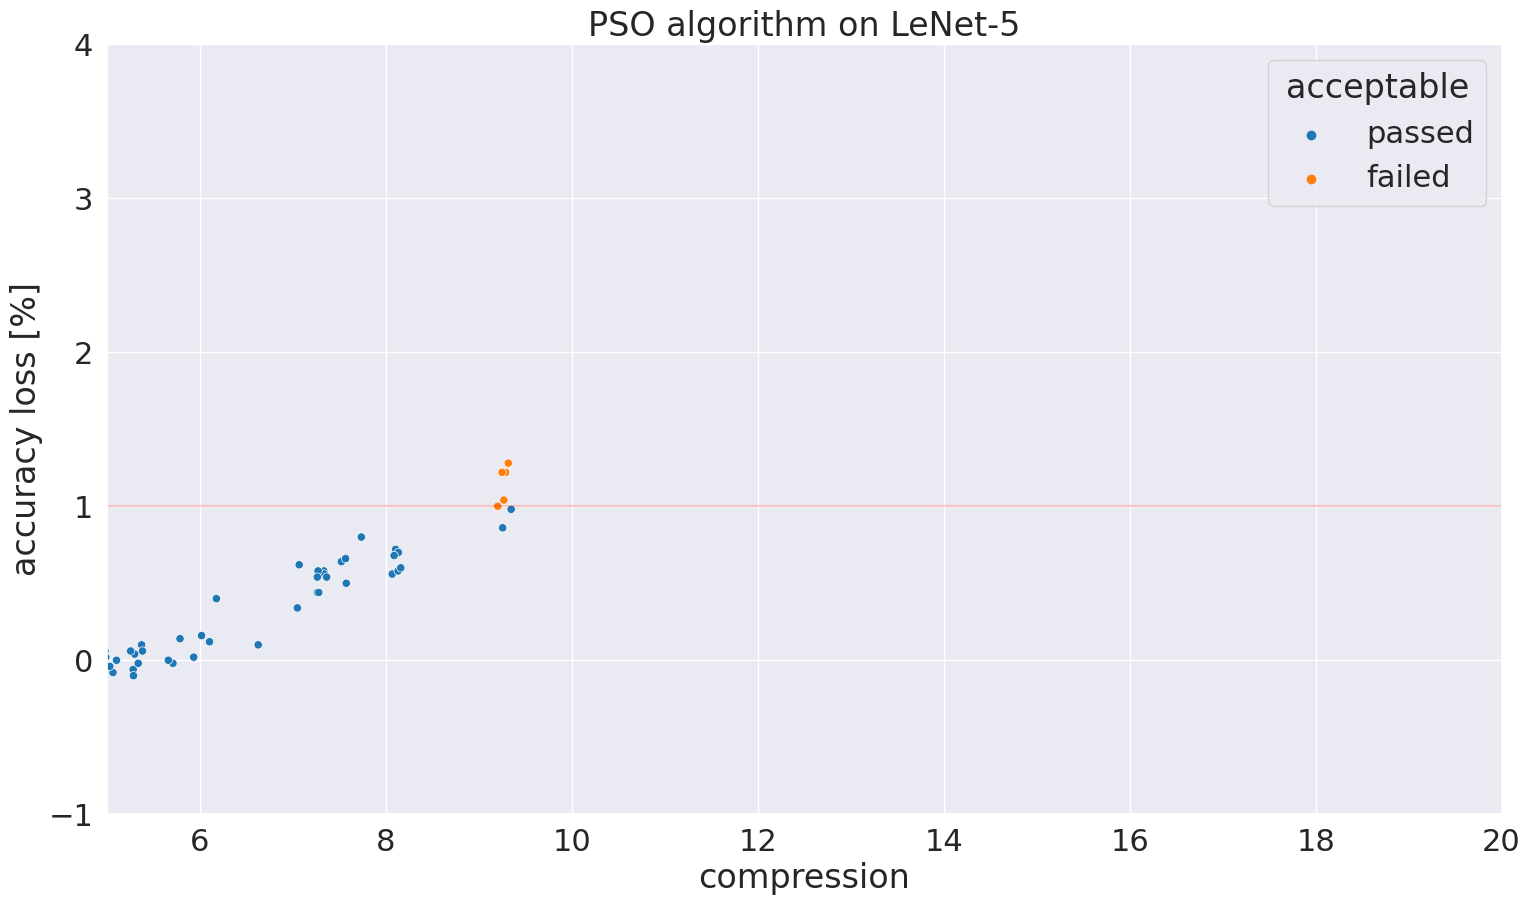

In [11]:
plot_alcr(pso_data)
plt.title('PSO algorithm on LeNet-5')